# Getting Acquainted with TSCC with an RNA-Sequencing Analysis Pipeline

**Authors**: Clarence Mah (ckmah@ucsd.edu) and Michelle Franc Ragsac (mragsac@eng.ucsd.edu)

---

**Notebook Information:**

This notebook covers some of the basic `UNIX` commands that are used to process RNA-sequencing data, including tools to perform sequence alignments. The goal of this notebook is to recognize common sequencing file types that are featured within most RNA-sequencing analysis pipelines.

---

## Evaluate Project Files and Initialize Analysis `conda` Environment

Within this first portion of the notebook, we're assuming that you've already logged into the Triton Shared Compute Cluster (TSCC) with your training account; the commands to do so are featured here for reference. The purpose of this section is to spend some time inspecting the files that you'll be using within your analysis. 

### Commands for Logging into TSCC and Submitting an Interactive Compute Job

### Inspect the Structure of the Directory for Module 4

In [1]:
# Since we're in the notebooks subdirectory, change one directory out before checking what's here
# with the cd (change directory) and ls (list) commands!
cd ..
ls -l

total 4160?2004l
-rw-r--r--@ 1 mragsac  staff  1625020 Sep  7 10:43 00_MR_Module4_Introduction-to-HPC-Presentation.pdf
-rw-r--r--  1 mragsac  staff     2859 Sep  7 10:45 README.md
drwxr-xr-x@ 8 mragsac  staff      256 Sep  8 09:17 data
drwxr-xr-x@ 5 mragsac  staff      160 Sep  8 10:13 notebooks
drwxr-xr-x@ 9 mragsac  staff      288 Sep  8 10:11 outputs


: 1

Within this module, we have two important directories, `data/` and `notebooks/`, that contain the interactive components.

Let's look inside the `data/` directory to see what's there! 

In [2]:
ls -l data/

total 50488
-rw-r--r--@ 1 mragsac  staff  12400379 Sep  7 10:47 yeast.fasta
-rw-r--r--@ 1 mragsac  staff   3135233 Sep  7 10:47 yeast.gtf
-rw-r--r--@ 1 mragsac  staff   5154724 Sep  7 10:47 yeast_R1.fastq
-rw-r--r--@ 1 mragsac  staff   5151354 Sep  7 10:47 yeast_R2.fastq


: 1

Within the data directory, we have four files present: 

* **`yeast.fasta`** contains the reference genome for yeast
* **`yeast.gtf`** is a genome annotation file for the yeast genome 
* **`yeast_R1.fastq`** is part of a hypothetical RNA-sequencing experiment in yeast and contains Read 1 
* **`yeast_R2.fastq`** is part of a hypothetical RNA-sequencing experiment in yeast and contains Read 2

Now that we know what files we havee, let's preview a short snippet of each file to see what's in them! 

In [3]:
# head allows you to preview a file; while the default number of lines is 10, let's set it to 5!
head -5 data/*

==> data/yeast.fasta <==
>chrI
CCACACCACACCCACACACCCACACACCACACCACACACCACACCACACC
CACACACACACATCCTAACACTACCCTAACACAGCCCTAATCTAACCCTG
GCCAACCTGTCTCTCAACTTACCCTCCATTACCCTGCCTCCACTCGTTAC
CCTGTCCCATTCAACCATACCACTCCGAACCACCATCCATCCCTCTACTT

==> data/yeast.gtf <==
chrI	sacCer3_ncbiRefSeqCurated	start_codon	130799	130801	0.000000	+	.	gene_id "NM_001178157.1"; transcript_id "NM_001178157.1"; 
chrI	sacCer3_ncbiRefSeqCurated	CDS	130799	131980	0.000000	+	0	gene_id "NM_001178157.1"; transcript_id "NM_001178157.1"; 
chrI	sacCer3_ncbiRefSeqCurated	stop_codon	131981	131983	0.000000	+	.	gene_id "NM_001178157.1"; transcript_id "NM_001178157.1"; 
chrI	sacCer3_ncbiRefSeqCurated	exon	130799	131983	0.000000	+	.	gene_id "NM_001178157.1"; transcript_id "NM_001178157.1"; 
chrI	sacCer3_ncbiRefSeqCurated	stop_codon	1807	1809	0.000000	-	.	gene_id "NM_001180043.1"; transcript_id "NM_001180043.1"; 

==> data/yeast_R1.fastq <==
@SRR6924582.1 1 length=76
TCAGATTTAGTCCATAAGGCAAACTTGTTACCACCTTTTCTAATGCTTAAAACGACACCGTT

: 1

---

# Performing Simple Quality Control on Raw Sequencing Data

As a warmup, we'll be looking at the yeast reference genome (`yeast.fasta`). 

<div class="alert alert-block alert-info">
    <p><b>Question 1:</b> How many chromosomes can be found within our reference genome (<code>yeast.fasta</code>) file?</p>
</div>

In [4]:
# Answer
grep ">" data/yeast.fasta | wc -l

      17


: 1

### Introduction to the FASTQ file format

When you get sequencing data back from a sequencing core (e.g., the Institue for Genomic Medicine, IGM, at UCSD has a sequencing core that many labs go to in order to get sequencing done for their experiments), it usually comes back in the `fastq` file format. 

`fastq` files usually have four lines per sequencing read entry: 

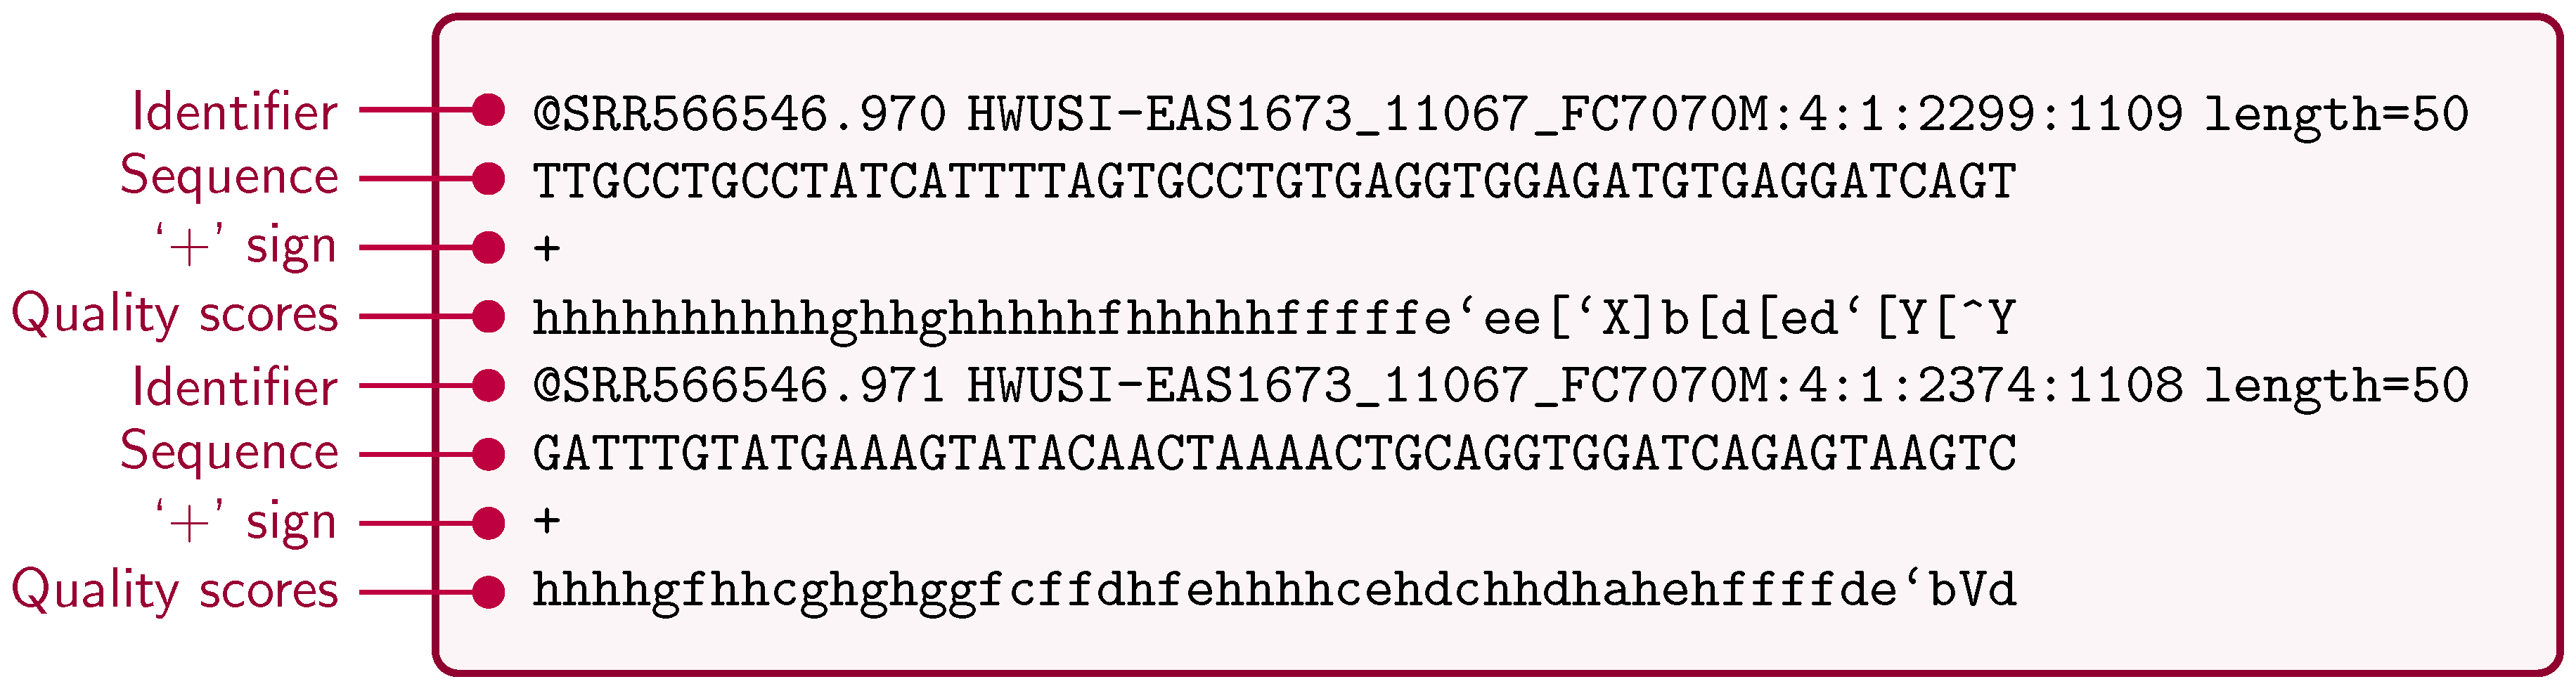

[Hosseini, Morteza, Diogo Pratas, and Armando J. Pinho. "A survey on data compression methods for biological sequences." Information 7.4 (2016): 56.](https://www.mdpi.com/2078-2489/7/4/56/htm)

- **Line 1** begins with a `@` character and is followed by a sequence identifier and an optional description (e.g., a FASTA title line)
- **Line 2** contains the raw sequence characters that were read off the sequencer
- **Line 3** begins with a `+` character and is optionally followed by the same sequence identifier (and any description) again
- **Line 4** encodes the quality values for the sequence featured in Line 2, and must contain the same number of symbols as letters in the Line 2 sequence

### Inspecting the `yeast_R1.fastq` and `yeast_R2.fastq` Files for this Demo

How many reads are in `yeast_R1.fastq`?

<div class="alert alert-block alert-info">
    <p><b>Question 2:</b> How many reads can be found within each of our sequencing files (<code>yeast_R1.fastq</code> and <code>yeast_R2.fastq</code>)?</p>
</div>

In [5]:
# Answer 
wc -l data/yeast_R*.fastq # determines number of lines in each file, still need to divide by 4!

   94080 data/yeast_R1.fastq
   94080 data/yeast_R2.fastq
  188160 total


: 1

### Generating a Sequencing Quality Control Report with `FastQC`

`fastqc` (https://www.bioinformatics.babraham.ac.uk/projects/fastqc/) is a commonly-used sequencing quality control tool that performs checks on raw sequence data that comes from high throughput sequencing pipelines. It provides a modular set of analyses that can be used to get a quick impression of whether or not the data has any issues that we should be aware of before any further analyses. 

Within this portion of our notebook, we'll be using `fastqc` to generate a quality control report of our `yeast_R1.fastq` and `yeast_R2.fastq` files! 

In [6]:
# Make a directory to hold the output of our analysis and then run fastqc 
# and specify our recently-created output directory with the -o parameter
mkdir -p outputs/fastqc_output
fastqc data/yeast_R1.fastq data/yeast_R2.fastq -o outputs/fastqc_output

Started analysis of yeast_R1.fastq
Approx 5% complete for yeast_R1.fastq
Approx 10% complete for yeast_R1.fastq
Approx 15% complete for yeast_R1.fastq
Approx 20% complete for yeast_R1.fastq
Approx 25% complete for yeast_R1.fastq
Approx 30% complete for yeast_R1.fastq
Approx 35% complete for yeast_R1.fastq
Approx 40% complete for yeast_R1.fastq
Approx 45% complete for yeast_R1.fastq
Approx 50% complete for yeast_R1.fastq
Approx 55% complete for yeast_R1.fastq
Approx 60% complete for yeast_R1.fastq
Approx 65% complete for yeast_R1.fastq
Approx 70% complete for yeast_R1.fastq
Approx 75% complete for yeast_R1.fastq
Approx 80% complete for yeast_R1.fastq
Approx 85% complete for yeast_R1.fastq
Approx 90% complete for yeast_R1.fastq
Approx 95% complete for yeast_R1.fastq
Analysis complete for yeast_R1.fastq
Started analysis of yeast_R2.fastq
Approx 5% complete for yeast_R2.fastq
Approx 10% complete for yeast_R2.fastq
Approx 15% complete for yeast_R2.fastq
Approx 20% complete for yeast_R2.fast

: 1

### Downloading `fastqc` Results from TSCC to a Local Computer using the `scp` Command

Now that we've run the `fastqc` software on our data, the next step is to view the results. `fastqc` outputs all of its results into an easy-to-read `html` file that you can open in your browser; however, TSCC doesn't have a browser! The next step that we'll need to complete is transferring our file from TSCC to our local computer using the `scp` command. 

---

# Mapping Sequencing Reads to a Reference Genome

Now that we've checked out our files and made sure that our raw data is of good quality, we can continue with the next step of the pipeline: mapping our reads to the reference genome. The purpose of mapping our reads is to figure out where each of our reads came from! To complete this step, we'll be using a software known as `STAR` (https://academic.oup.com/bioinformatics/article/29/1/15/272537). 

Generally, there are a few steps to complete that are common amongst alignment tools: 

1. **Generate a genome index**, a file that is used for the aligner to quickly determine the locations of genome annotations within a genome of interest
2. **Align sequencing reads** using the genome index file to determine their identity (e.g., what gene or isoform they're associated with)
3. **Sort and index alignments** to genome-sorted order instead of read-aligned order to make alignments easier to evaluate
4. **Perform quality control** on the alignments to determine how many reads aligned to the genome and to what locations

#### STAR Documentation
You can find the documentation for STAR at the following URL: https://github.com/alexdobin/STAR/blob/master/doc/STARmanual.pdf.

### Step 1: Generating a Genome Index for the Yeast Genome using `STAR`

In order to generate a genome index with `STAR`, we used the following parameters: 

```
--runMode: genomeGenerate mode
--genomeDir: /path/to/store/genome_indices
--genomeFastaFiles: /path/to/FASTA_file
--sjdbGTFfile: /path/to/GTF_file
```

However, since this step can take some time, we've performed it for you and stored the file in an easy-to-access location! Generally, you only need to index a genome once for the system that you'll be performing an analysis on. Sometimes, you can even download pre-generated genome indices for the software tools that you're using! 

In [7]:
STAR \
    --runThreadN 1 \
    --runMode genomeGenerate \
    --genomeDir outputs/STAR_yeast_reference \
    --genomeFastaFiles data/yeast.fasta \
    --sjdbGTFfile data/yeast.gtf

	STAR --runThreadN 1 --runMode genomeGenerate --genomeDir outputs/STAR_yeast_reference --genomeFastaFiles data/yeast.fasta --sjdbGTFfile data/yeast.gtf
	STAR version: 2.7.9a   compiled:  :/Users/cshl/data/STAR/STAR/source
Sep 08 10:13:53 ..... started STAR run
Sep 08 10:13:53 ... starting to generate Genome files
Sep 08 10:13:53 ..... processing annotations GTF
!!!!! WARNING: --genomeSAindexNbases 14 is too large for the genome size=12157105, which may cause seg-fault at the mapping step. Re-run genome generation with recommended --genomeSAindexNbases 10
Sep 08 10:13:53 ... starting to sort Suffix Array. This may take a long time...
Sep 08 10:13:53 ... sorting Suffix Array chunks and saving them to disk...
Sep 08 10:14:03 ... loading chunks from disk, packing SA...
Sep 08 10:14:04 ... finished generating suffix array
Sep 08 10:14:04 ... generating Suffix Array index
Sep 08 10:14:10 ... completed Suffix Array index
Sep 08 10:14:10 ..... inserting junctions into the genome indices
Sep 08

: 1

### Step 2: Align Sequencing Reads to the Reference Genome with `STAR`

Now that we have built our genome index, we can quickly align our reads to the reference yeast genome.

```
--genomeDir: /path/to/genome_indices_directory
--runThreadN: number of threads / cores
--readFilesIn: /path/to/FASTQ_file
--outFileNamePrefix: prefix for all output files
--outSAMtype: output filetype (SAM default)
--outSAMunmapped: what to do with unmapped reads
```

In [8]:
STAR \
    --genomeDir outputs/STAR_yeast_reference \
    --runThreadN 1 \
    --readFilesIn data/yeast_R1.fastq data/yeast_R2.fastq \
    --outFileNamePrefix outputs/STAR_alignment_results/yeast \
    --outSAMtype BAM SortedByCoordinate \
    --outSAMunmapped Within

	STAR --genomeDir outputs/STAR_yeast_reference --runThreadN 1 --readFilesIn data/yeast_R1.fastq data/yeast_R2.fastq --outFileNamePrefix outputs/STAR_alignment_results/yeast --outSAMtype BAM SortedByCoordinate --outSAMunmapped Within
	STAR version: 2.7.9a   compiled:  :/Users/cshl/data/STAR/STAR/source
Sep 08 10:14:38 ..... started STAR run
Sep 08 10:14:38 ..... loading genome
Sep 08 10:14:41 ..... started mapping
Sep 08 10:14:47 ..... finished mapping
Sep 08 10:14:47 ..... started sorting BAM
Sep 08 10:14:47 ..... finished successfully


: 1

Let's look at the log file for `STAR` alignment statistics!

In [9]:
cat outputs/STAR_alignment_results/yeastLog.final.out

                                 Started job on |	Sep 08 10:14:38
                             Started mapping on |	Sep 08 10:14:41
                                    Finished on |	Sep 08 10:14:47
       Mapping speed, Million of reads per hour |	14.11

                          Number of input reads |	23520
                      Average input read length |	150
                                    UNIQUE READS:
                   Uniquely mapped reads number |	20353
                        Uniquely mapped reads % |	86.53%
                          Average mapped length |	150.54
                       Number of splices: Total |	559
            Number of splices: Annotated (sjdb) |	513
                       Number of splices: GT/AG |	556
                       Number of splices: GC/AG |	0
                       Number of splices: AT/AC |	0
               Number of splices: Non-canonical |	3
                      Mismatch rate per base, % |	0.49%
                         Deletion rate pe

: 1

<div class="alert alert-block alert-info">
    <p><b>Question 3:</b> What percentage of our reads were uniquely mapped? And multi-mapped? What do these terms mean?</p>
</div>

### Step 3: Sort and Index Alignments using `samtools`

The output of alignments is commonly in the Sequence Alignment Map (`sam`) or Binary Alignment Map (`bam`) file format. The `sam` file format is a text-based format for storing alignment information in a series of tab-delimited ASCII columns; you can find more information on the `sam` and `bam` file formats at the following URL: https://samtools.github.io/hts-specs/SAMv1.pdf. 

A commonly-used tool to manage `sam` and `bam` files for downstream analysis is `samtools` (https://github.com/samtools/samtools).  

In [10]:
# Sort the bam file output from STAR using the samtools sort command
samtools sort \
    outputs/STAR_alignment_results/yeastAligned.sortedByCoord.out.bam > \
    outputs/STAR_alignment_results/yeastAligned.sortedByName.out.bam
    
# Index the sorted bam using the samtools index command
samtools index \
    outputs/STAR_alignment_results/yeastAligned.sortedByName.out.bam

: 1

Now that we've finished sorting and indexing our alignment file, let's preview what files are in our `STAR_alignment_results/` directory!

In [11]:
ls outputs/STAR_alignment_results/

yeastAligned.sortedByCoord.out.bam    yeastLog.out
yeastAligned.sortedByName.out.bam     yeastLog.progress.out
yeastAligned.sortedByName.out.bam.bai yeastSJ.out.tab
yeastLog.final.out


: 1

We can also view what our alignments look like using the `samtools view` and `samtools flagstat` commands! 

In [12]:
# The samtools view command allows you to see what the uncompressed bam file (so, a sam file) looks like!
# However, it will show you the direct alignment results, which can be difficult to look at...
samtools view outputs/STAR_alignment_results/yeastAligned.sortedByName.out.bam | head

SRR6924582.17978	99	chrI	28848	255	75M	=	28938	162	GGTGTATCTTAAATACTAAAGTGAGCTGACTACCCTTTTGAGTGCCCTATGTGACCTCTGATCTCGAAAGTAAAC	AAAAAEEEEEEEEEEEEEEEEEEEEEEEEE/EEEEAEEEEEEEEAAEEEEEEEEEEEEEE/EEEEEAEEEEEEEE	NH:i:1	HI:i:1	AS:i:139	nM:i:3
SRR6924582.17978	147	chrI	28938	255	72M3S	=	28848	-162	TCACAGCCACTTTTTGTTGCGGACACTGACGGGATGTGTTGTGAATATTTTAAACCTTAAAAGTTTATGTTGTTA	E<<EAEEEEA<EEEEEEEEE/EEEEEEEEEAEAE/EA/EEE/AEEEEEEEEEEEEEEEEEEEEEEE6EEEAAAAA	NH:i:1	HI:i:1	AS:i:139	nM:i:3
SRR6924582.2921	99	chrI	29172	255	40M6D35M	=	29258	158	CCGGCATTCCAGCAAGGTAACTATATACGCTTTTTTTTTCTTTGAAATTGTACCTGCCAAGCTTGCTACACTTGG	AAAAAEEEEEEEEEAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEAEAEE	NH:i:1	HI:i:1	AS:i:107	nM:i:7
SRR6924582.2921	147	chrI	29258	255	26M4I46M	=	29172	-158	AACTCCGTTTTTCAGAGATTAGATTCTTTTTTTTTTTTTTGAAGAAAAGGCAGCCAAGTTACGTCATACAGAAAAC	EEAA/E/6EEEE/A////EE///EE6EEEEEEEEEEEEAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEAAAAA	NH:i:1	HI:i:1	AS:i:107	nM:i:7
SRR6924582.4987	163	chrI	35482	255	76M	=	35620	214	C

: 1

In [13]:
# The flagstat command prints a more relevant summary of the results versus the view command!
samtools flagstat outputs/STAR_alignment_results/yeastAligned.sortedByName.out.bam

49962 + 0 in total (QC-passed reads + QC-failed reads)
47040 + 0 primary
2922 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
45933 + 0 mapped (91.94% : N/A)
43011 + 0 primary mapped (91.43% : N/A)
47040 + 0 paired in sequencing
23520 + 0 read1
23520 + 0 read2
43010 + 0 properly paired (91.43% : N/A)
43010 + 0 with itself and mate mapped
1 + 0 singletons (0.00% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


: 1

### Step 4: Perform Quality Control on Alignment Files by Running `fastqc` to Generate Summary Statistics

With our alignment complete, we can evaluate the quality of the alignment by running `fastqc` on the sorted `bam` files!

In [14]:
fastqc outputs/STAR_alignment_results/yeastAligned.sortedByName.out.bam -o outputs/fastqc_output

Started analysis of yeastAligned.sortedByName.out.bam
Approx 5% complete for yeastAligned.sortedByName.out.bam
Approx 10% complete for yeastAligned.sortedByName.out.bam
Approx 15% complete for yeastAligned.sortedByName.out.bam
Approx 20% complete for yeastAligned.sortedByName.out.bam
Approx 25% complete for yeastAligned.sortedByName.out.bam
Approx 30% complete for yeastAligned.sortedByName.out.bam
Approx 35% complete for yeastAligned.sortedByName.out.bam
Approx 40% complete for yeastAligned.sortedByName.out.bam
Approx 45% complete for yeastAligned.sortedByName.out.bam
Approx 50% complete for yeastAligned.sortedByName.out.bam
Approx 55% complete for yeastAligned.sortedByName.out.bam
Approx 65% complete for yeastAligned.sortedByName.out.bam
Approx 70% complete for yeastAligned.sortedByName.out.bam
Approx 75% complete for yeastAligned.sortedByName.out.bam
Approx 80% complete for yeastAligned.sortedByName.out.bam
Approx 85% complete for yeastAligned.sortedByName.out.bam
Approx 90% complete

: 1

Remember to transfer the results to your local computer to view the output HTML file!

---

## Generate Counts Matrix for Gene Expression 

Now that we've determined the genomic coordinates of where each read is able to map to using `STAR`, we can now cross-reference this information to the genomic coordinates of features using a genome annotation file (e.g., `gtf` files). These features can be exons, gene, or even transcripts! In this demo, we're evaluating **genes**. 

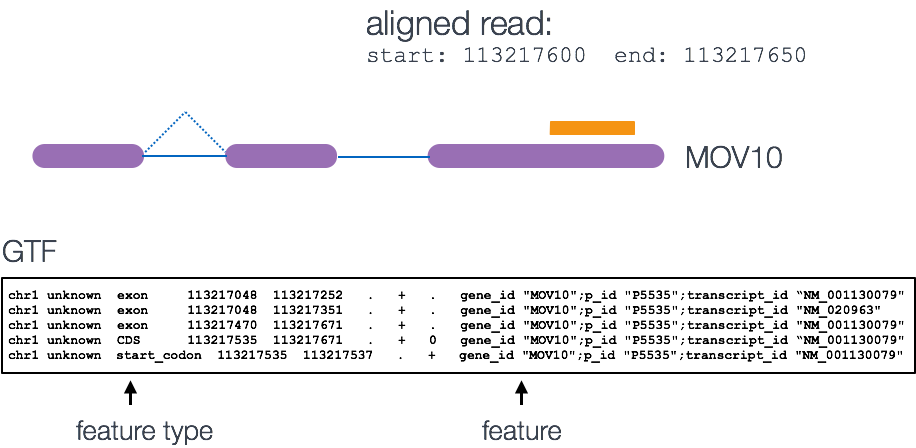

In order to generate our counts matrix, we'll be using a common tool known as `featureCounts` (https://academic.oup.com/bioinformatics/article/30/7/923/232889) found under the `subread` package (http://subread.sourceforge.net). You can find the documentation for `featureCounts` at the following link: http://subread.sourceforge.net/featureCounts.html. 

### Running `featureCounts` on our Sorted `bam` File to Generate a Counts Matrix

- `-a` genome annotation file (`GTF`) where each entry is a feature
- `-o` output counts file
- the last parameter below is the input read file (`bam`)

In [15]:
featureCounts \
    -a data/yeast.gtf \
    -o outputs/final_counts_matrix.txt \
    outputs/STAR_alignment_results/yeastAligned.sortedByName.out.bam
    
# This command will generate two files:
# final_counts_matrix.txt and final_counts_matrix.txt.summary


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.0.1

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 1 BAM file                                       ||
||                           o yeastAligned.sortedByName.out.bam              ||
||                                                                            ||
||             Output file : final_counts_matrix.txt                          ||
||                 Summary : final_counts_matrix.txt.summary     

: 1

### Preview the Counts Matrix Summary Results

In [16]:
cat outputs/final_counts_matrix.txt.summary

Status	outputs/STAR_alignment_results/yeastAligned.sortedByName.out.bam
Assigned	38579
Unassigned_Unmapped	4029
Unassigned_Read_Type	0
Unassigned_Singleton	0
Unassigned_MappingQuality	0
Unassigned_Chimera	0
Unassigned_FragmentLength	0
Unassigned_Duplicate	0
Unassigned_MultiMapping	5228
Unassigned_Secondary	0
Unassigned_NonSplit	0
Unassigned_NoFeatures	2024
Unassigned_Overlapping_Length	0
Unassigned_Ambiguity	102


: 1

---

## Performing Final Quality Control Sumnary Reports with `multiqc`

`multiqc` is a tool that aggregates results from several tools used in bioinformatics pipelines to generate a single HTML report with plots to visualize and compare various quality control metrics between samples. The tools supported by `multiqc` span various next-generating sequencing analysis pipelines and is quite useful for when you need to quickly provide somebody (e.g., your PI) information on if an analysis "worked"! 

In [17]:
# Run multiqc on the entire output directory!
multiqc outputs -o outputs/multiqc_output


  /// ]8;id=718126;https://multiqc.info\MultiQC]8;;\ 🔍 | v1.11

|           multiqc | Search path : /Users/mragsac/Documents/BISB-Bootcamp-2021/day3/module4_introduction-to-hpc/outputs
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 33/33  port.htmloutput/yeast_R2_fastqc.htmleneInfo.tab
|    feature_counts | Found 1 reports
|              star | Found 1 reports
|            fastqc | Found 3 reports
|           multiqc | Compressing plot data
|           multiqc | Previous MultiQC output found! Adjusting filenames..
|           multiqc | Use -f or --force to overwrite existing reports instead
|           multiqc | Report      : outputs/multiqc_output/multiqc_report_1.html
|           multiqc | Data        : outputs/multiqc_output/multiqc_data_1
|           multiqc | MultiQC complete


: 1

### Downloading `multiqc` Results from TSCC to a Local Computer using the `scp` Command

Similar to `fastqc`, to view the results of `multiqc`, we'll have to transfer the HTML output to our local computer using the `scp` command. Here's a refresher on the command if you need it: 